
# Exploring Spatial Transcriptomics: A Dive into Visium Data Analysis in Python

**Author:** Angel Galvez Merchan

Spatial transcriptomics is transforming our understanding of tissue biology by enabling researchers to measure gene expression within the spatial context of intact tissues. Unlike traditional single-cell RNA sequencing (scRNA-seq), which dissociates cells and loses spatial information, spatial transcriptomics retains the physical location of gene expression, opening up powerful insights into tissue architecture, cellular niches, and microenvironments in health and disease.

## Overview of Spatial Transcriptomics Technologies

Several technologies have emerged in recent years, each with distinct approaches, strengths, and trade-offs:



| Technology            | Origin / Platform                     | Resolution       | Approach                                 | Unique Features & Notes                                                     | Use Case Fit                 |
|-----------------------|----------------------------------------|------------------|------------------------------------------|------------------------------------------------------------------------------|------------------------------|
| **10x Visium**        | 10x Genomics (2019)                    | ~55 µm (multi-cell) | Slide-based capture on barcoded spots    | Mature ecosystem; open-source-friendly   | General-purpose profiling    |
| **Slide-seq / V2**    | Macosko Lab, Harvard (2019–2020)       | ~10 µm (near single-cell) | Barcoded beads on slide                   | Higher spatial resolution; requires complex bead registration                | Fine-grained spatial detail  |
| **MERFISH / seqFISH** | Zhuang Lab / Raj Lab (2015–2021)       | Subcellular       | Multiplexed in situ hybridization         | Single-molecule precision; targeted gene panels                              | Subcellular mapping          |
| **GeoMx / CosMx**     | NanoString Technologies (2020–2022)    | CosMx: single-cell<br>GeoMx: low | Barcoded ROI-based probe hybridization   | Flexible RNA/protein profiling; strong FFPE support                          | Targeted profiling in clinical |
| **Stereo-seq**        | BGI Genomics (2021)                    | ~0.5 µm (subcellular) | DNA nanoball arrays                       | Ultra-high resolution; cutting-edge tech; high data volume                   | Ultra-high-res spatial mapping |



## Why Focus on Visium?


In this blog post, we’ll focus on **10x Genomics Visium** because it provides a particularly smooth transition into spatial transcriptomics for those already familiar with scRNA-seq. Its data structure and analysis workflow align closely with standard scRNA-seq practices, allowing researchers to reuse tools like `scanpy` and `anndata` with minimal adaptation. Combined with a robust commercial ecosystem, standardized outputs, and strong community support, Visium is an ideal starting point for single-cell experts looking to explore spatial context.

In fact, this was how I personally began exploring spatial transcriptomics: by extending familiar scRNA-seq workflows into spatial data, and gradually discovering the rich new layers it adds to biological interpretation. I hope this approach helps you make the transition as smoothly and enjoyably as it did for me.




## Imports and installs

In [1]:
%%capture

# Installs
!pip3 install igraph leidenalg scanpy squidpy anndata plotly

# Imports
import scanpy as sc
import squidpy as sq
import anndata
import os
import tarfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Read data

Let’s kick things off by loading a real Visium dataset. For this tutorial, we’ll use the "V1_Human_Lymph_Node" sample provided by 10x Genomics, which is conveniently available through scanpy’s built-in datasets module.

This dataset comes from a human lymph node section and includes gene expression data, spatial coordinates, and a histology image.

In [2]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()

/var/folders/np/ym8qscs97x38jk22s8r1phxr0000gn/T/ipykernel_35530/3706321379.py:1: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Understanding the Visium data structure

Let's inspect the adata object:

In [3]:
adata

AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
adata.uns['spatial']['V1_Human_Lymph_Node'].keys()

dict_keys(['images', 'scalefactors', 'metadata'])

At first glance, the Visium dataset looks a lot like a standard scRNA-seq dataset. And that is because they share the same foundation: a **gene count matrix**, with genes as rows and observations (in this case, spatial spots) as columns.

But Visium adds **two extra layers** of spatial context:

1. **Coordinates** – Each spot on the slide is associated with spatial (x, y) coordinates, enabling us to map gene expression back onto tissue morphology.

2. **Tissue Image** – Alongside the expression data, Visium includes an image of the tissue section. This makes it possible to overlay gene expression patterns on top of actual histology, bridging morphology and molecular data.

These extra layers turn a familiar data object into something more informative, adding new dimensions that change how we explore and interpret the data.


## Shared foundation: the Gene Count Matrix



This matrix is functionally very similar to what you would find in scRNA-seq workflows. Each spot (a small region of tissue) acts like a pseudo-cell, and each entry in the matrix represents the expression level of a gene in that spot. Because of this similarity, many pre-processing steps (depth-normalization, log transformation, dimensionality reduction, clustering, etc.) can be performed using the same tools and techniques used for scRNA-seq.

### QC metrics

Most QC metrics used in scRNA-seq can be translated to Visium data. We can use the same function in `scanpy` to calculate those metrics.

In [5]:
# Add annotation for mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Filters

Just like in single cell RNA-seq, it makes sense to filter out spots with very few detected genes, as these are: often low-quality or empty regions.

In [6]:
# Filter out spots with less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)

### Normalization

In most scRNA-seq workflows, we perform cell-depth normalization to correct for differences in sequencing depth or capture  efficiency, followed by a log transformation to stabilize variance. However, there is an important caveat:

#### Visium != single cells

Although Visium data looks like single-cell data (a gene-by-spot matrix), each spot captures transcripts from a multi-cellular region of the tissue, making it more akin to a series of bulk RNA-seq samples with spatial information.

That difference matters, especially when thinking about how to normalize the data. In spatial transcriptomics, the total number of transcripts in a spot might actually reflect meaningful biology, like differences in tissue density, cellularity, or metabolic activity.

Let’s visualize the total counts per spot:

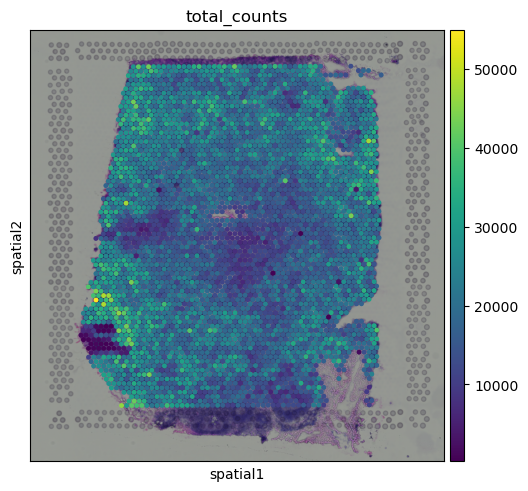

In [7]:
sq.pl.spatial_scatter(
    adata,
    color="total_counts",
    size=1.5
)

You might notice that total counts show some spatial structure and aren’t randomly distributed across the tissue. In some cases, these patterns may align with known tissue morphology, hinting at potential biological relevance. This opens up the possibility that total counts may reflect meaningful differences, like local cell density or transcriptional activity.

#### So... what should we do?

**There’s no single best answer right now.** How to normalize spatial transcriptomics data is still an open question in the field, and different approaches may be better suited for different downstream analyses.

Sometimes, the spatial structure you see in total counts may reflect real biology, but other times, it could stem from technical artifacts, such as differences in how well certain regions of the slide captured transcripts. Some areas might just perform better than others in terms of RNA capture, leading to apparent "hotspots" or "cold spots" that aren't necessarily biologically meaningful.

For the purpose of this tutorial, we will keep things simple and apply the standard scRNA-seq normalization approach. But it is important to be aware of the assumptions behind this method, and the limitations it brings when working with spatial data.

In [8]:
# Normalize to 10,000 total counts per spot
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform the data
sc.pp.log1p(adata)

This gives us a log-normalized expression matrix, similar to what we would use in single-cell workflows. Just keep in mind that we are treating total counts as technical noise, which may not always be true.

### Highly variable genes

As in scRNA-seq, we can select highly variable genes (HVGs) to focus on the most informative features for downstream analysis:

In [9]:
sc.pp.highly_variable_genes(adata)

>  **Note:** Some studies suggest that combining highly variable genes with spatially variable genes can improve cell type clustering performance (see [this preprint](https://pmc.ncbi.nlm.nih.gov/articles/PMC11537352/) for details). For simplicity, we'll stick with standard HVGs here.


### Dimensionality reduction and visualization

You can apply the same dimensionality reduction and visualization pipeline used in scRNA-seq. After normalization and HVG selection, standard steps like PCA, nearest neighbor graph construction, leiden clustering and UMAP can be used to project the data into a low-dimensional space:

In [10]:
# Run PCA
sc.pp.pca(adata, n_comps=50)

# Calculate neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Leiden clustering
sc.tl.leiden(adata, resolution=0.8)

# Computing UMAP
sc.tl.umap(adata)

/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/np/ym8qscs97x38jk22s8r1phxr0000gn/T/ipykernel_35530/2662806496.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 

You can try to identify cell types in Visium data using the same approach as in single-cell RNA-seq: by plotting known marker genes. For example, to explore B cell populations, we can visualize expression of a few canonical B cell markers:

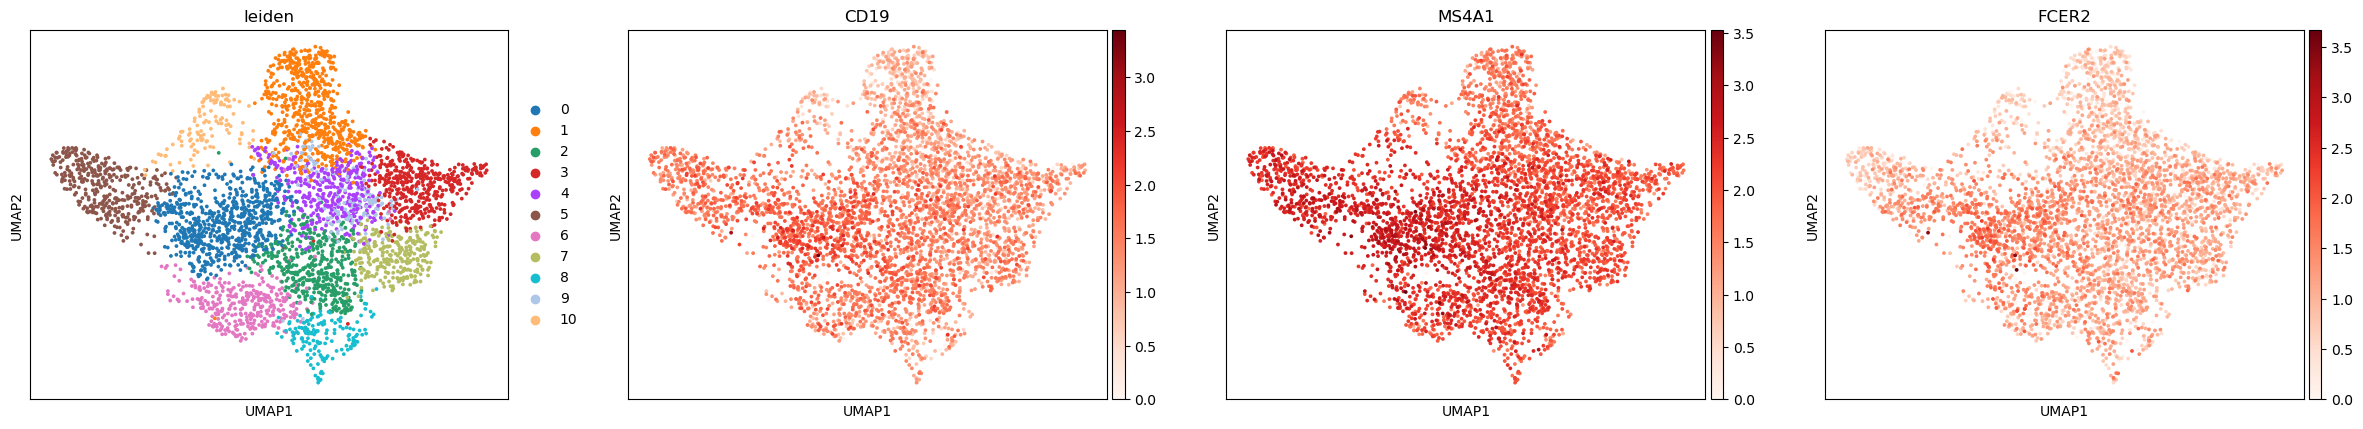

In [11]:
# Visualizing marker genes
sc.pl.umap(adata, color=['leiden', 'CD19', 'MS4A1', 'FCER2'], cmap = 'Reds')

This brings us back to the key difference we mentioned earlier: each dot in the UMAP represents a spot, not an individual cell. Unlike in scRNA-seq, we don’t always see crisp clusters corresponding to distinct cell types. Instead, marker gene expression often appears broadly distributed, reflecting the fact that many spots likely contain mixtures of cell types. In the case of the lymph node, where B cells are abundant, this result makes sense. It is somewhat expected that most spots contain at least some B cell transcript signal.

## The Unique Layers of Spatial Transcriptomics



So far, we have worked with the gene count matrix, a structure that closely mirrors scRNA-seq. Now, let’s look at what makes spatial transcriptomics different: the additional layers of spatial context.

### Histology Image

Alongside the gene expression data, Visium also provides a **histology image** of the tissue section. This image is stored within the `adata.uns` dictionary and can be accessed as a standard NumPy array, with pixel values encoded in RGB format:

In [12]:
img = adata.uns['spatial']['V1_Human_Lymph_Node']['images']['hires']
print(f"Shape: {img.shape}, Type: {type(img)}, Dtype: {img.dtype}")

# First top left pixels
img[:3, :3, :]

Shape: (2000, 1921, 3), Type: <class 'numpy.ndarray'>, Dtype: float32


array([[[0.5882353 , 0.6       , 0.5764706 ],
        [0.58431375, 0.6       , 0.5686275 ],
        [0.5882353 , 0.6       , 0.5686275 ]],

       [[0.5882353 , 0.6       , 0.57254905],
        [0.5882353 , 0.6       , 0.5764706 ],
        [0.58431375, 0.6       , 0.5764706 ]],

       [[0.58431375, 0.6       , 0.5803922 ],
        [0.58431375, 0.6       , 0.5764706 ],
        [0.58431375, 0.59607846, 0.57254905]]], dtype=float32)

We can visualize the tissue image using:

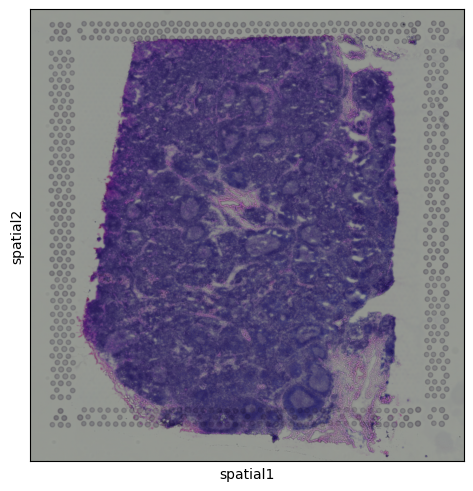

In [13]:
sq.pl.spatial_scatter(adata)

#### Calculating features in image

Tissue images can contain one or more channels. For example, fluorescence-based data might include separate channels for different markers. Even in standard histology images like H&E, we can extract useful information by calculating image-based features.

These features might include pixel intensity, texture, or structural patterns associated with different tissue regions or staining types. While in this example the image isn't rich in contrast and has no multi-channel content, we willll still use it to demonstrate how image features can be extracted and used in spatial analyses.

In [14]:
# Define image container
img = sq.im.ImageContainer.from_adata(adata)

`squidpy`'s `calculate_image_features` function, when used with the default option (`features="summary"`), computes a set of basic image features for each spot, including:

- Mean intensity  
- Standard deviation  
- Quantiles (e.g., median, 10th/90th percentiles)  
- Texture features
- Edge features (like edge density using Sobel filters)  

These features are computed using a **circular region around each spot** on the tissue image, providing a local summary of the image content beneath each capture area.


In [15]:
sq.im.calculate_image_features(
    adata,
    img,
    features="summary",
    key_added="image_features"
)

  0%|          | 0/4032 [00:00<?, ?/s]/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from ann

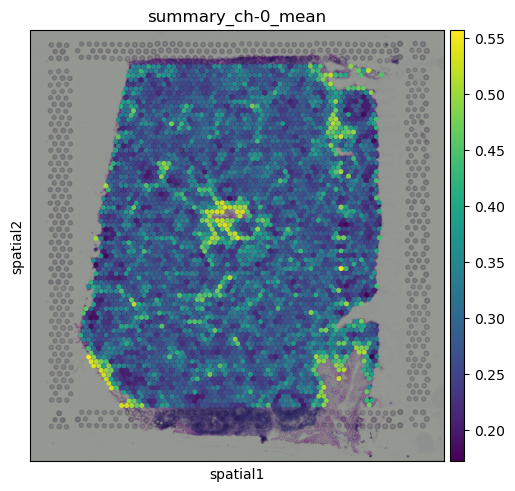

In [16]:
# Transfer to obs for plotting
adata.obs["summary_ch-0_mean"] = adata.obsm["image_features"]["summary_ch-0_mean"]
sq.pl.spatial_scatter(
    adata,
    color="summary_ch-0_mean",
    size=1.5
)

This plot represents the mean pixel intensity from the image under each spot, giving us a rough idea of local brightness across the tissue.


#### Clustering on image features


Since the image features are numerical values (just like gene expression), we can use them for clustering. This allows us to group spots based on similarities in their local tissue appearance.


/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


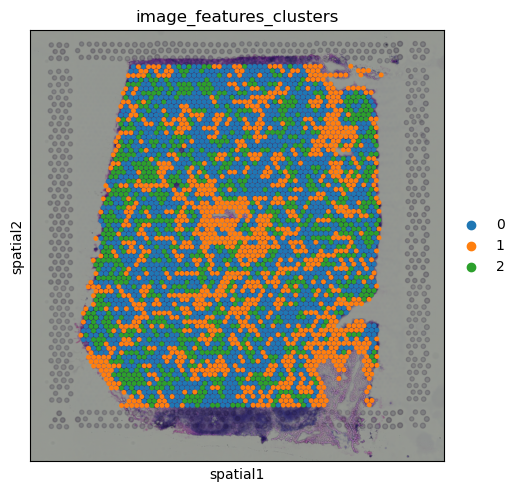

In [17]:
sc.pp.neighbors(adata, use_rep="image_features")
sc.tl.leiden(adata, key_added="image_features_clusters", resolution = 0.1)

#adata.uns.pop('image_features_clusters_colors')
sq.pl.spatial_scatter(
    adata,
    color="image_features_clusters",
    size=1.5
)


### Spatial Coordinates

Each spot in Visium data comes with associated **(x, y) coordinates** that indicate its physical location on the tissue slide. These spatial coordinates allow us to map gene expression data back onto the tissue’s layout.

You can access them in `adata.obsm`

In [18]:
# Extracting spatial coordinates
coords = adata.obsm["spatial"]
print(f"Shape: {coords.shape}, Type: {type(coords)}, Dtype: {coords.dtype}")

# First few coordinates
coords[:3, :]

Shape: (4032, 2), Type: <class 'numpy.ndarray'>, Dtype: int64


array([[8346, 6982],
       [4270, 1363],
       [2635, 8074]])

This returns an array with the x and y positions (in pixels) for each spot on the slide.



### Building a Spatial Neighborhood Graph

To incorporate spatial relationships into our analysis, we can build a **spatial neighborhood graph**. This graph defines which spots are considered neighbors based on their physical proximity on the slide.

With `squidpy`, this is easily done using:

In [19]:
sq.gr.spatial_neighbors(adata, coord_type="grid")

The resulting graph is stored in `adata.obsp["spatial_connectivities"]`

In [20]:
adata.obsp["spatial_connectivities"].shape

(4032, 4032)

We can also visualize the graph to see how spots are linked together.

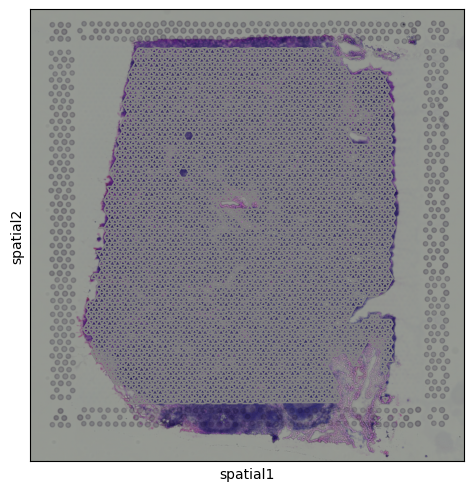

In [21]:
sq.pl.spatial_scatter(adata, connectivity_key="spatial_connectivities")

## Integrating the Layers of Spatial Transcriptomics

So far, we've explored the core components of spatial transcriptomics: the gene count matrix, the histology image, and the spatial coordinates. Each of these layers is valuable on its own, but the real power of spatial transcriptomics emerges when we **combine them**.

By integrating gene expression with spatial context and image-derived features, we can uncover patterns that would be invisible in standard scRNA-seq. This is where spatial transcriptomics moves beyond simply measuring gene expression. It starts to reveal how cells are organized, how they interact, and how structure relates to function.

In the following sections, we will explore a few ways to combine these layers for spatially aware analysis.


### Gene expression features observed on tissue


One of the most powerful aspects of spatial transcriptomics is the ability to visualize gene expression directly on the tissue. This allows us to observe how specific genes are spatially distributed and how they relate to tissue structure.

For example, we can visualize expression of the T cell marker CD3E:

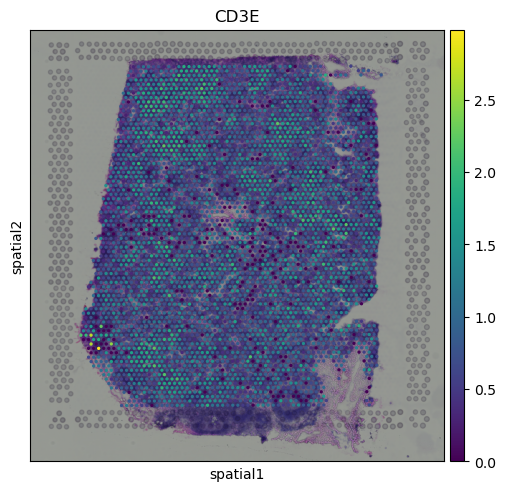

In [22]:
sq.pl.spatial_scatter(adata, color = 'CD3E')

We can see that CD3E expression is broadly distributed across the tissue, with some localized areas of higher expression. This pattern likely reflects regions with enriched T cell presence.

### Spatial Mapping of Gene Expression Clusters

We can visualize the Leiden clusters **computed from the gene expression data** directly on the tissue. This
allows us to see whether spots that are transcriptionally similar are also spatially close to one another and whether distinct expression programs correspond to specific tissue regions.

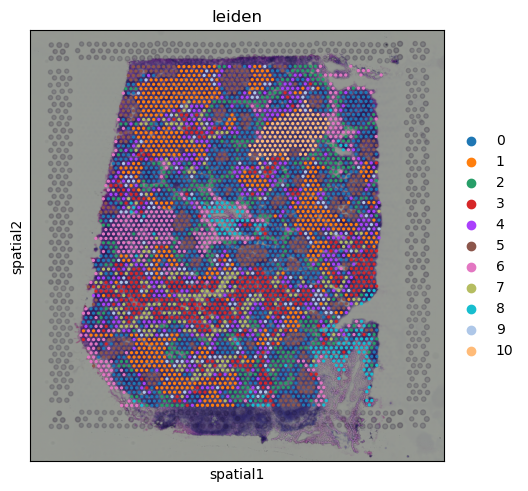

In [23]:
sq.pl.spatial_scatter(adata, color = 'leiden')

Cluster 9 stands out as a spatially localized group of spots. To understand what characterizes this cluster, we can examine its marker genes:

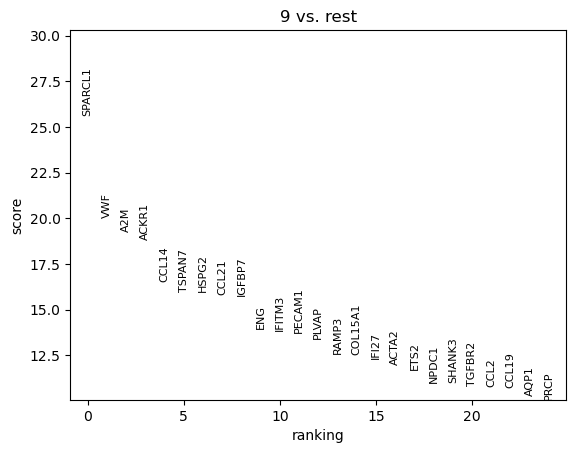

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=25, groups = ['9'])

The results indicate that cluster 9 is enriched for interferon-induced genes, suggesting that this region of the tissue is actively responding to interferon signaling. To further support this, we can visualize the expression of additional known interferon-stimulated genes that were not among the top-ranked markers.


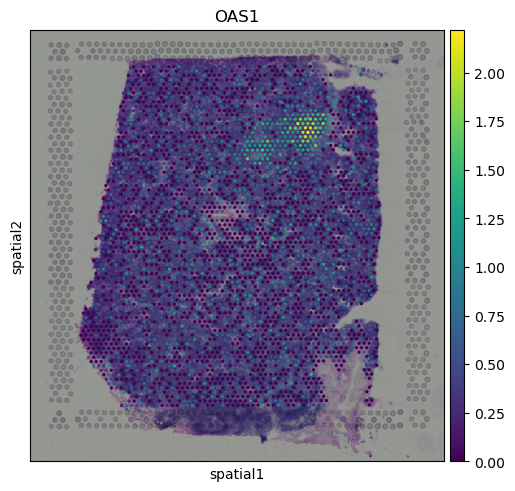

In [25]:
sq.pl.spatial_scatter(adata, color = ['OAS1'])

### Finding Spatially Variable Genes

In addition to identifying genes that vary across transcriptional clusters, we can also look for genes that show **spatial structure**, that is, genes whose expression levels are **non-randomly distributed across the tissue**.


One way to quantify this is with **Moran's I**, a measure of spatial autocorrelation. Genes with high Moran’s I values tend to be expressed in spatially coherent patterns, rather than scattered randomly across spots.

We can compute this using:


In [26]:
sq.gr.spatial_autocorr(adata, mode="moran")

Note that this functions uses the spatial neighborhood graph that we computed in previous sections. We can check the top spatially structured genes:

In [27]:
# Top spatially structured genes
adata.uns["moranI"]["I"].sort_values(ascending = False)[0:15]

FDCSP      0.701889
IGHG2      0.656459
MT-CO1     0.609527
CR2        0.598975
MT-CO2     0.586977
CXCL13     0.546026
MT-ND4     0.538226
CLU        0.526424
MT-ND3     0.518973
MT-ATP6    0.515217
MT-CYB     0.498500
CCL19      0.497364
JCHAIN     0.494780
IGLC3      0.488655
MT-ND1     0.474826
Name: I, dtype: float64

And we can visualize some of them, confirming their spatial structure:

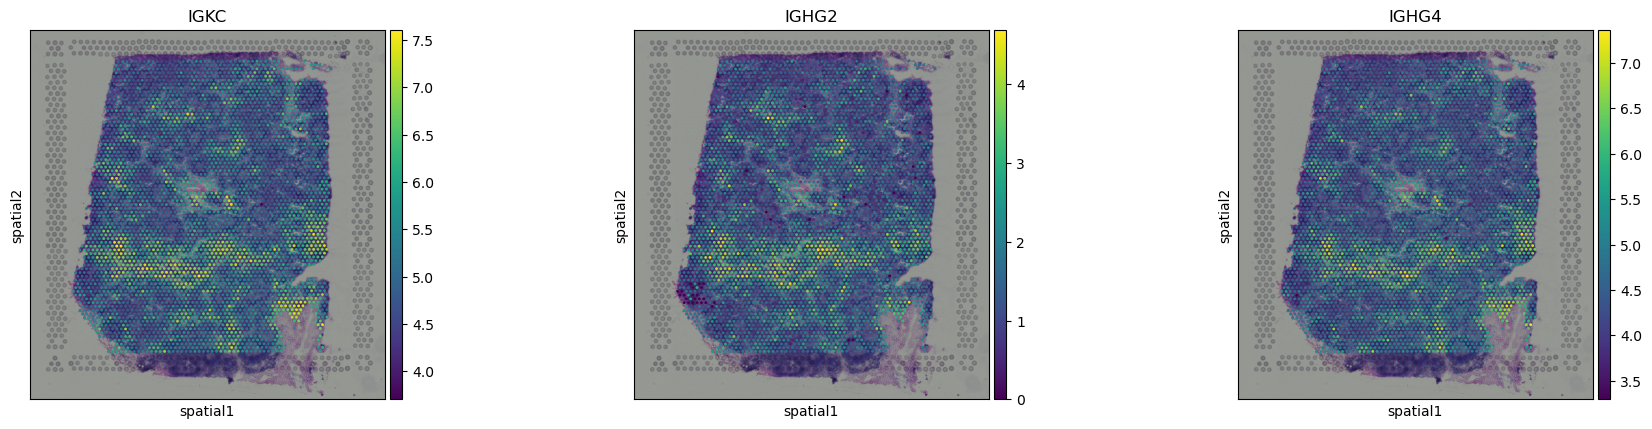

In [28]:
sq.pl.spatial_scatter(adata, color = ['IGKC','IGHG2','IGHG4'])

### Segmenting the Tissue into Spatial Domains

A key goal in spatial transcriptomics is to define **tissue regions** that reflect both molecular identity and physical organization. In contrast to clustering based purely on gene expression, spatial domain identification focuses on grouping spots that are transcriptionally similar and spatially close, capturing functional zones within the tissue.

There are many sophisticated methods for identifying spatial domains — including [concordex](https://www.biorxiv.org/content/10.1101/2023.06.28.546949v2), [STAGATE](https://www.nature.com/articles/s41467-022-29439-6), and others. Working with these tools and deeply exploring spatial domain detection could easily be a blog post (or several) on its own.

For now, we will use a simple but intuitive approach that captures the essence of spatial domain identification. We take the **principal components (PCs)** from the PCA of the gene count matrix (a compact summary of transcriptional variation) and **concatenate them with the spatial coordinates** of each spot. This creates a feature space that incorporates both molecular identity and physical location.

While this method lacks the complexity of more specialized spatial domain tools, it is surprisingly effective at revealing spatially coherent, transcriptionally distinct regions. It also serves as a great way to build intuition about how gene expression and tissue architecture align.

/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


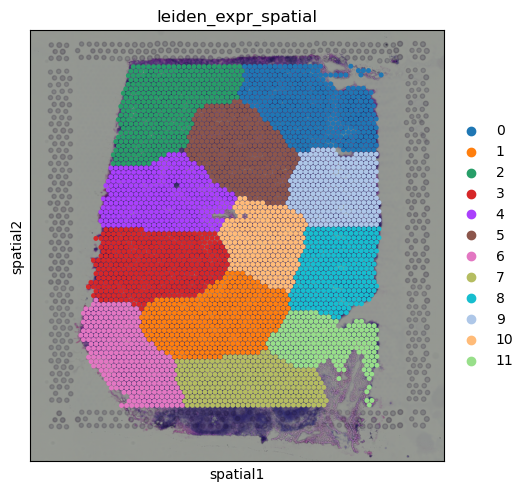

In [29]:
# Extract PCA and spatial coordinates
X_pca = adata.obsm["X_pca"][:, :10]  # use first 10 PCs
X_spatial = adata.obsm["spatial"]

# Concatenate PCA + spatial into a new matrix
X_combined = np.concatenate([X_pca, X_spatial], axis=1)
adata.obsm["X_expr_space"] = X_combined

# Build neighbor graph and cluster using the combined features
sc.pp.neighbors(adata, use_rep="X_expr_space")
sc.tl.leiden(adata, key_added="leiden_expr_spatial", resolution = 0.5)

# Visualize
sq.pl.spatial_scatter(adata, color="leiden_expr_spatial", size=1.5)

But wait, something looks off. After running clustering on the combined PCA and spatial coordinates, we get a very clean segmentation of the tissue, but the regions look **suspiciously like purely spatial clusters**.

If we inspect the input for or combined matrix, we can see the issue:

The PC values look like this:

In [30]:
print(X_pca[0])

[-2.4115045  -0.97213066  1.4502726  -0.91960466 -0.8045087   0.61556554
 -0.4716722   0.47577804 -0.03903842  0.0295859 ]


But the spatial coordinates are on a completely different scale:

In [31]:
print(X_spatial[0])

[8346 6982]


Because the spatial coordinates have much larger magnitudes, they dominate the clustering, overpowering the transcriptional signal. The result is clustering that is driven almost entirely by physical location.

To fix this, we simply need to standardize both the PCA and spatial features so they contribute equally:

/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


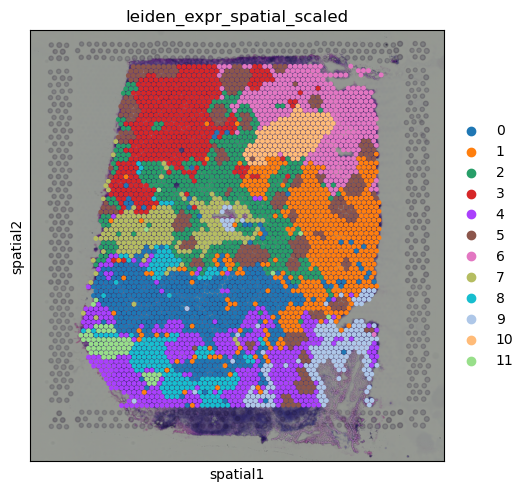

In [32]:
# Scale values
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

scaler_spatial = StandardScaler()
X_spatial_scaled = scaler_spatial.fit_transform(X_spatial)

# Combine into one matrix
X_combined = np.concatenate([X_pca_scaled, X_spatial_scaled], axis=1)
adata.obsm["X_expr_spatial_scaled"] = X_combined

# Neighbors + clustering
sc.pp.neighbors(adata, use_rep="X_expr_spatial_scaled")
sc.tl.leiden(adata, key_added="leiden_expr_spatial_scaled", resolution = 0.5)

# Visualize
sq.pl.spatial_scatter(adata, color="leiden_expr_spatial_scaled", size=1.5)

We now get regions that reflect a balance of spatial coherence and transcriptional similarity, a much more meaningful segmentation of the tissue

Here is a question for you: **What happens if you use 20 principal components instead of 10?**  What do you think might change?

I will leave this as an exercise for the reader. Take a moment to guess before running the code below!


/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


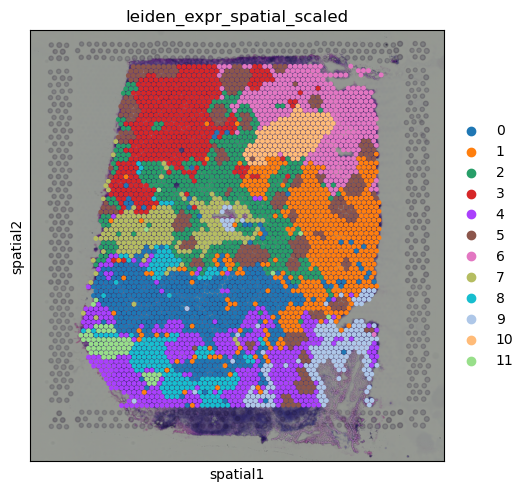

In [33]:
X_pca = adata.obsm["X_pca"][:, :10]  # use first 10 PCs
X_spatial = adata.obsm["spatial"]

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

scaler_spatial = StandardScaler()
X_spatial_scaled = scaler_spatial.fit_transform(X_spatial)

X_combined = np.concatenate([X_pca_scaled, X_spatial_scaled], axis=1)
adata.obsm["X_expr_spatial_scaled"] = X_combined

sc.pp.neighbors(adata, use_rep="X_expr_spatial_scaled")
sc.tl.leiden(adata, key_added="leiden_expr_spatial_scaled", resolution = 0.5)

sq.pl.spatial_scatter(adata, color="leiden_expr_spatial_scaled", size=1.5)

## Conclusions

In this tutorial, we explored the foundational concepts of spatial transcriptomics using 10x Visium data, with a perspective rooted in scRNA-seq workflows. Beginning with the familiar gene count matrix, we examined how spatial data builds on this structure by introducing additional layers, such as spatial coordinates and histology images.

This tutorial serves as an entry point into the field. While there is much more to explore (from spatial domain modeling, to cell–cell interaction analysis) we hope it has provided a solid foundation and demonstrated how spatial transcriptomics extends naturally from single-cell analysis, while offering entirely new opportunities for discovery.

Happy exploring!
